# Introduction to rio-tiler

The goal of this notebook is to give a quick introduction of the main rio-tiler features.

In [98]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Requirements

To be able to run this notebook you'll need the following requirements:
- rio-tiler~= 2.0

In [45]:
# !pip install rio-tiler --pre rio-tiler

In [88]:
import morecantile
from rio_tiler.io import COGReader
from rio_tiler.profiles import img_profiles
from rio_tiler.models import ImageData, Metadata

## Data

For this demo we will use some NAIP data hosted on Azure.

https://azure.microsoft.com/fr-fr/services/open-datasets/catalog/naip/


The data is similar to the data hosted on [AWS](https://registry.opendata.aws/naip/), but using the one on Azure is easier because it offers direct `http` access without needing an AWS account.

In [50]:
# For this DEMO we will use this file
src_path = "https://naipblobs.blob.core.windows.net/naip/v002/al/2019/al_60cm_2019/30087/m_3008701_ne_16_060_20191115.tif"

## rio_tiler.io.COGReader

In `rio-tiler` 2.0 we introduced COGReader, which is a python class providing usefull methods to read and inspect any GDAL/rasterio raster dataset.

Docs: [https://cogeotiff.github.io/rio-tiler/readers/#cogreader](https://cogeotiff.github.io/rio-tiler/readers/#cogreader) 

In [56]:
?COGReader

### Info

Read GDAL/Rasterio dataset metadata

In [58]:
# As for Rasterio, using context manager is a good way to 
# make sure the dataset are closed when we exit.
with COGReader(src_path) as cog:
    print("rasterio dataset:")
    print(cog.dataset)
    
    print("metadata from rasterio:")
    print(cog.dataset.meta)
    
    # Using rio-tiler Info() method
    info = cog.info()
    print("rio-tiler dataset info:")
    print(cog.info().dict())

print(cog.dataset.closed)

rasterio dataset:
<open DatasetReader name='https://naipblobs.blob.core.windows.net/naip/v002/al/2019/al_60cm_2019/30087/m_3008701_ne_16_060_20191115.tif' mode='r'>
metadata from rasterio:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 10710, 'height': 12300, 'count': 4, 'crs': CRS.from_epsg(26916), 'transform': Affine(0.6, 0.0, 410238.0,
       0.0, -0.6, 3430182.0)}
rio-tiler dataset info:
{'bounds': (-87.94024818743992, 30.935228146251212, -87.87233769345903, 31.002283423611786), 'center': (-87.90629294044948, 30.9687557849315, 11), 'minzoom': 11, 'maxzoom': 17, 'band_metadata': [('1', {}), ('2', {}), ('3', {}), ('4', {})], 'band_descriptions': [('1', ''), ('2', ''), ('3', ''), ('4', '')], 'dtype': 'uint8', 'nodata_type': 'None', 'colorinterp': ['red', 'green', 'blue', 'undefined'], 'scale': None, 'offset': None, 'colormap': None}
True


### Metadata

Read dataset GDAL Metadata and return basic data statistics

In [94]:
with COGReader(src_path) as cog:
    meta = cog.metadata()
    # output from metadata() method is a pydantic model
    # Checkout the docs https://cogeotiff.github.io/rio-tiler/models/#metadata
    assert isinstance(meta, Metadata)
    print(meta)

bounds=(-87.94024818743992, 30.935228146251212, -87.87233769345903, 31.002283423611786) center=(-87.90629294044948, 30.9687557849315, 11) minzoom=11 maxzoom=17 band_metadata=[('1', {}), ('2', {}), ('3', {}), ('4', {})] band_descriptions=[('1', ''), ('2', ''), ('3', ''), ('4', '')] dtype='uint8' nodata_type='None' colorinterp=['red', 'green', 'blue', 'undefined'] scale=None offset=None colormap=None statistics={'1': ImageStatistics(percentiles=[23.0, 153.0], min=4.0, max=255.0, std=31.125265337094447, histogram=[[36318.0, 109564.0, 248443.0, 288972.0, 158108.0, 55899.0, 13321.0, 1682.0, 630.0, 471.0], [4.0, 29.1, 54.2, 79.30000000000001, 104.4, 129.5, 154.60000000000002, 179.70000000000002, 204.8, 229.9, 255.0]]), '2': ImageStatistics(percentiles=[49.0, 151.0], min=15.0, max=254.0, std=23.24771515268198, histogram=[[8394.0, 29607.0, 89535.0, 297082.0, 394143.0, 88651.0, 4373.0, 729.0, 587.0, 307.0], [15.0, 38.9, 62.8, 86.69999999999999, 110.6, 134.5, 158.39999999999998, 182.299999999999

#### Plot Histogram values

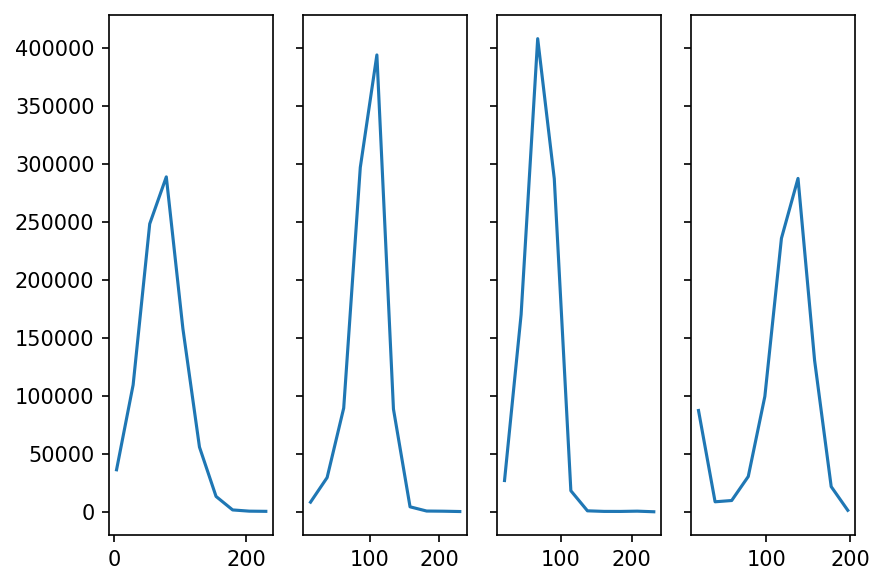

In [128]:
fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True, dpi=150)
# Red
axs[0].plot(meta.statistics["1"].histogram[1][0:-1], meta.statistics["1"].histogram[0])

# Green
axs[1].plot(meta.statistics["2"].histogram[1][0:-1], meta.statistics["2"].histogram[0])

# Blue
axs[2].plot(meta.statistics["3"].histogram[1][0:-1], meta.statistics["3"].histogram[0])

# NIR
axs[3].plot(meta.statistics["4"].histogram[1][0:-1], meta.statistics["4"].histogram[0])

### Preview

Read a low resolution version of the data (useful when working with COG, because this method will only fetch the overview layer it needs)

In [65]:
with COGReader(src_path) as cog:
    # By default `preview()` will return an array with its longest dimension lower or equal to 1024px
    img = cog.preview()
    print(img.data.shape)
    assert isinstance(img, ImageData)

(4, 1024, 892)


#### The ImageData class

To ease data manipulation, `rio-tiler` version 2.0 uses a new `ImageData` class that holds the arrays returned by rio-tiler/rasterio low level functions.

Docs: https://cogeotiff.github.io/rio-tiler/models/#imagedata

In [70]:
print(f"width: {img.width}")
print(f"height: {img.height}")
print(f"bands: {img.count}")
print(f"crs: {img.crs}")
print(f"bounds: {img.bounds}")

# print(img.data)
# print(img.mask)

width: 892
height: 1024
bands: 4
crs: EPSG:26916
bounds: BoundingBox(left=410238.0, bottom=3422802.0, right=416664.0, top=3430182.0)


#### Display the data

<class 'rio_tiler.models.ImageData'>
(4, 1024, 892)
<class 'numpy.ndarray'>
(1024, 892, 4)


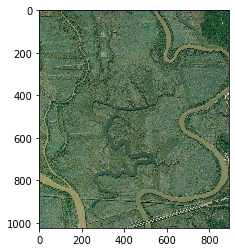

In [76]:
# Rasterio doesn't use the same axis order than visualization libraries (e.g matplotlib, PIL)
# in order to display the data we need to change the order (using rasterio.plot.array_to_image).
# the ImageData class wraps the rasterio function in the `data_as_image()` method.
print(type(img))
print(img.data.shape)

image = img.data_as_image()
# data_as_image() returns a numpy.ndarray
print(type(image))
print(image.shape)

# Use only the first 3 bands (RGB)
imshow(image[:,:,0:3])

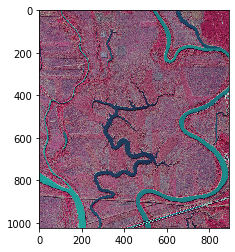

In [77]:
# Display NRG image
# The NAIP imagery has 4 bands Red, Green, Blue, NIR
imshow(image[:,:,[3,0,1]])

#### Using Expression

`rio-tiler` reader methods accept `indexes` option to select the bands you want to read, but also `expression` to perform band math.

In [85]:
with COGReader(src_path) as cog:
    # Return only the last band
    nir_band = cog.preview(indexes=4)
    print(nir_band.data.shape)
    print(nir_band.data.dtype)

(1, 1024, 892)
uint8


(1, 1024, 892)
float64
NDVI range:  -0.6951219512195121 0.9148936170212766


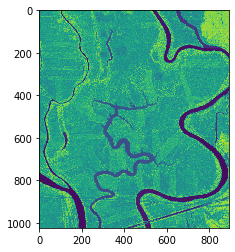

In [84]:
with COGReader(src_path) as cog:
    # Apply NDVI band math
    # (NIR - RED) / (NIR + RED)
    ndvi = cog.preview(expression="(b4-b1)/(b4+b1)")
    print(ndvi.data.shape)
    print(ndvi.data.dtype)
    print("NDVI range: ", ndvi.data.min(), ndvi.data.max())

image = ndvi.post_process(in_range=(-1,1))
imshow(image.data[0])

### Tile

Read data for a specific slippy map tile coordinates

In [130]:
with COGReader(src_path) as cog:
    print(f"MinZoom (WebMercator): {cog.minzoom}")
    print(f"MaxZoom (WebMercator): {cog.maxzoom}")
    print(f"Bounds: {cog.bounds}")

MinZoom (WebMercator): 11
MaxZoom (WebMercator): 17
Bounds: (-87.94024818743992, 30.935228146251212, -87.87233769345903, 31.002283423611786)


In [150]:
# rio-tiler defaults to the WebMercator Grids. The grid definition is provided by the morecantile module
# Docs: https://github.com/developmentseed/morecantile
tms = morecantile.tms.get("WebMercatorQuad")
print(repr(tms))

# Get the list of tiles for the COG minzoom 
with COGReader(src_path) as cog:
    tile_cover = list(tms.tiles(*cog.bounds, zooms=cog.minzoom))

print(f"Nb of Z{cog.minzoom} Mercator tiles: {len(tile_cover)}")
print(tile_cover)

<TileMatrixSet title='Google Maps Compatible for the World' identifier='WebMercatorQuad'>
Nb of Z11 Mercator tiles: 2
[Tile(x=523, y=838, z=11), Tile(x=524, y=838, z=11)]


In [143]:
with COGReader(src_path) as cog:
    img_1 = cog.tile(*tile_cover[0])
    print(img_1.data.shape)

    img_2 = cog.tile(*tile_cover[1])
    print(img_2.data.shape)

(4, 256, 256)
(4, 256, 256)


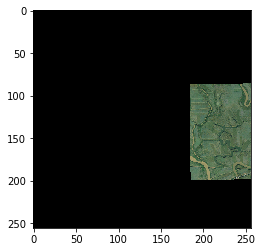

In [163]:
imshow(img_1.data_as_image()[:,:,0:3])

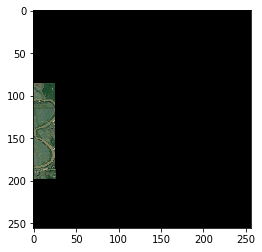

In [162]:
imshow(img_2.data_as_image()[:,:,0:3])

(1, 256, 256)


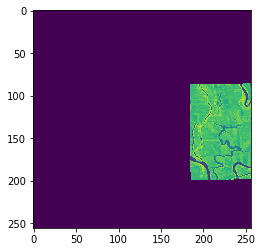

In [159]:
with COGReader(src_path) as cog:
    ndvi = cog.tile(*tile_cover[0], expression="(b4-b1)/(b4+b1)")
    print(ndvi.data.shape)

image = ndvi.post_process(in_range=(-1,1))
imshow(image.data[0])

### Part 

Read data for a given bounding box

In [165]:
with COGReader(src_path) as cog:
    # As for the `preview()` method, the `part()` method will limit the output array to `max_size=1024`
    img = cog.part((-87.92238235473633, 30.954131465929947, -87.87843704223633, 30.97996389724008))
    print(img.data.shape)
    print(img.bounds)
    print(img.crs)

(4, 602, 1024)
BoundingBox(left=-87.92238235473633, bottom=30.954131465929947, right=-87.87843704223633, top=30.97996389724008)
EPSG:4326


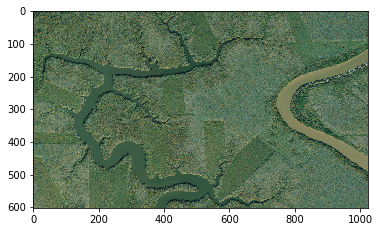

In [164]:
imshow(img.data_as_image()[:,:,0:3])

### Point

Read the pixel value for a specific lon/lat coordinate

In [166]:
with COGReader(src_path) as cog:
    # As for the `preview()` method, the `part()` method will limit the output array to `max_size=1024`
    values = cog.point(-87.92238235473633, 30.954131465929947)
print(values)

[88, 117, 83, 134]
